# LSTM Autoencoder 
## Tennessee Eastman Process Simulation Dataset

Source: https://www.kaggle.com/datasets/averkij/tennessee-eastman-process-simulation-dataset

In [123]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from model.autoencoder import LSTMAutoencoder, LSTMAutoencoderTransformer
from data.process import TEPDataLoader
from data.utils import get_missing_values_table

import plotly.graph_objects as go
import plotly.express as px 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Exploratory Data Analysis
### Loading datasets

A total of 4 datasets are available, already split into train and test. From the data source, the following complete description is available: 

* Each dataframe contains 55 columns:

  * Column 1 ('faultNumber') ranges from 1 to 20 in the “Faulty” datasets and represents the fault type in the TEP. The “FaultFree” datasets only contain fault 0 (i.e. normal operating conditions).

  * Column 2 ('simulationRun') ranges from 1 to 500 and represents a different random number generator state from which a full TEP dataset was generated (Note: the actual seeds used to generate training and testing datasets were non-overlapping).

  * Column 3 ('sample') ranges either from 1 to 500 (“Training” datasets) or 1 to 960 (“Testing” datasets). The TEP variables (columns 4 to 55) were sampled every 3 minutes for a total duration of 25 hours and 48 hours respectively. Note that the faults were introduced 1 and 8 hours into the Faulty Training and Faulty Testing datasets, respectively.

* Columns 4 to 55 contain the process variables; the column names retain the original variable names.

In [8]:
# create the loader class instance
loader = TEPDataLoader('data/raw')

# load the training and test datasets
X_train_faulty, X_train_normal = loader.load_training_datasets()
X_test_faulty, X_test_normal = loader.load_testing_datasets()

5it [01:19, 15.87s/it]
1it [00:03,  3.24s/it]
10it [02:26, 14.67s/it]
1it [00:06,  6.91s/it]


### Checking data quality
Initially, let's cehck if there is any missing data in the datasets. 

In [9]:
# let's check first for any columns with missing values
display(get_missing_values_table(X_train_faulty))
display(get_missing_values_table(X_train_normal))
display(get_missing_values_table(X_test_faulty))
display(get_missing_values_table(X_test_normal))

Your selected dataframe has 55 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Your selected dataframe has 55 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Your selected dataframe has 55 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Your selected dataframe has 55 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Good! No missing data for any of the columns. This is somehow expected, since this dataset is generated from a simulated process. 

### Data Understanding
Now, let's have a look at some normal and faulty simulations, to better understand what this data means. We pick the first simulation for a normal and faulty condition. Since there can be several kinds of faults, we also choose a single one for visualization. The resulting charts are displayed below, we can notice the following:
* The data is noisy. Therefore, a low-pass filter could be applied to them in a later pre-processing step.
* There is a clear distinction between a fault and normal operation between the signals. 
  * Look for example how the "xmeas_4" variable is different between them
* Variable "xmeas_9" looks like discrete signal, as it keeps switching between fixed values.

In [10]:
def plot_simulation_data(df, simulation_run, title, fault_number=0):
    process_variables = df.columns[4:]
    df_sim = df[(df.simulationRun == simulation_run)&(df.faultNumber==fault_number)]
    df_melt = pd.melt(df_sim, id_vars=['sample'], value_vars=process_variables, var_name='variable', value_name='value')
    rp = sns.relplot(data=df_melt, x='sample', y='value', col='variable', kind='line', 
                col_wrap=6, height=2,
                 facet_kws={'sharey': False, 'sharex': True})
    rp.fig.suptitle(f'{title}: Simulation #{simulation_run}')

def plot_simulation_variable(df, simulation_run, title, variable, fault_number=0):
    fig, ax = plt.subplots(figsize=(7,4))
    df_sim = df[(df.simulationRun == simulation_run)&(df.faultNumber==fault_number)]
    sns.lineplot(data=df_sim, x='sample', y=variable, ax=ax)
    fig.suptitle(f'{title}: Simulation #{simulation_run} - {variable}')

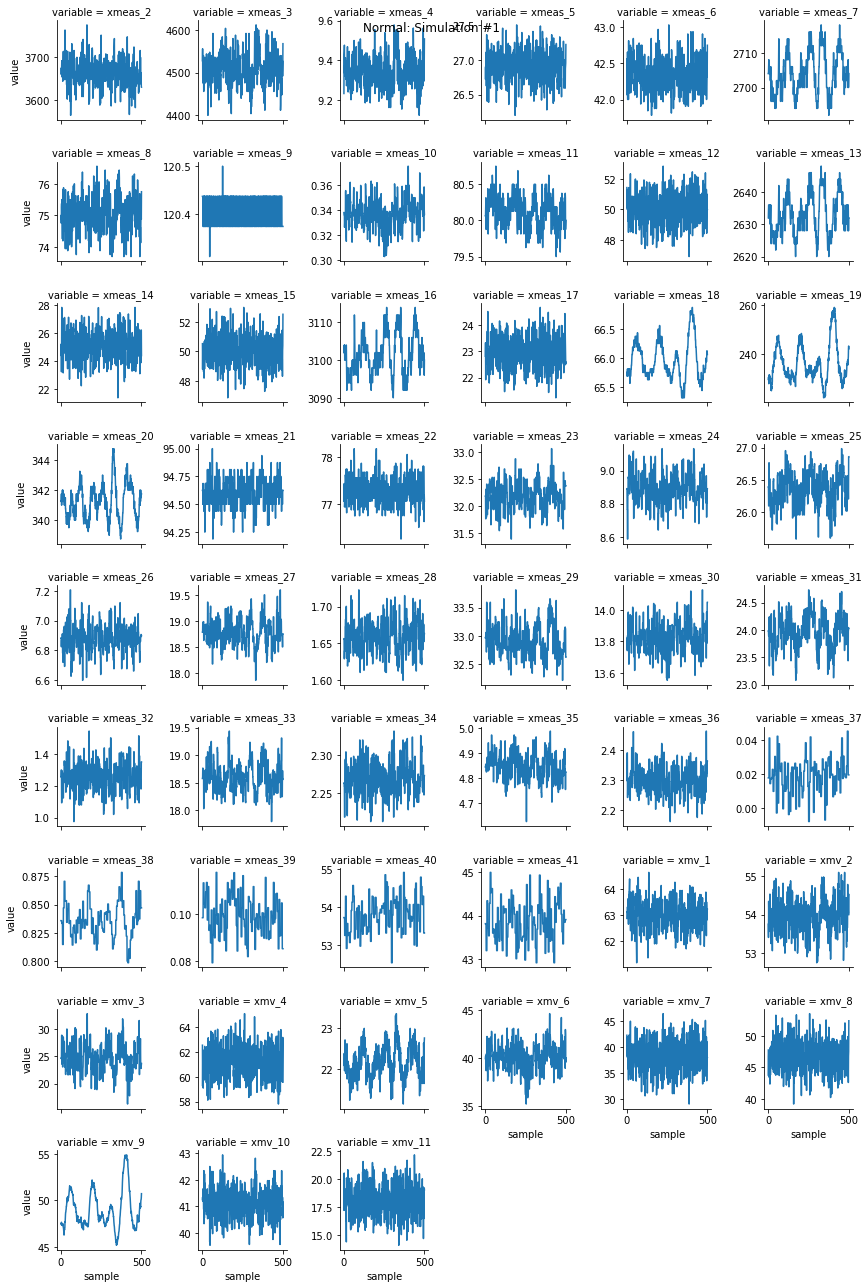

In [80]:
plot_simulation_data(X_train_normal, 1, 'Normal')

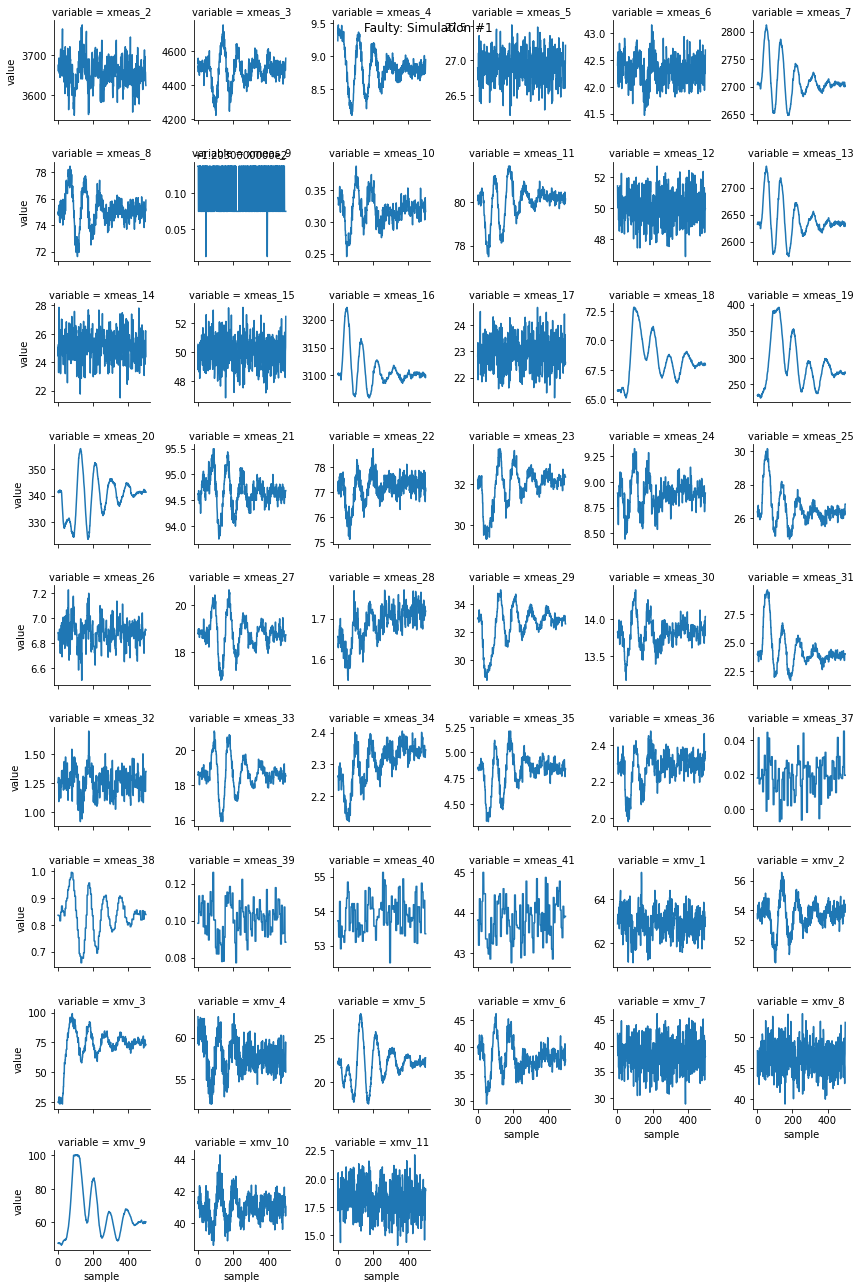

In [81]:
plot_simulation_data(X_train_faulty, 1,'Faulty', 1)

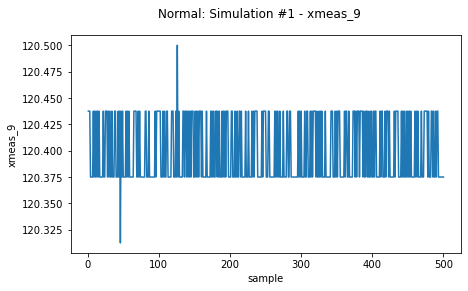

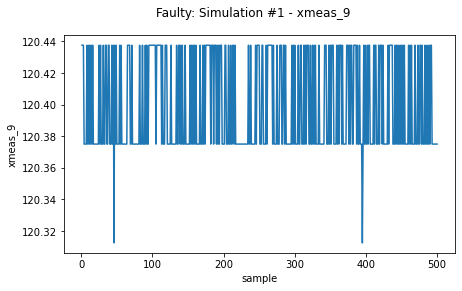

In [106]:
plot_simulation_variable(X_train_normal, 1, 'Normal', 'xmeas_9')
plot_simulation_variable(X_train_faulty, 1, 'Faulty', 'xmeas_9', 1)

## Data Preparation

In [101]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.signal import butter,filtfilt,medfilt

class LowPassFilter(BaseEstimator, TransformerMixin):
    def __init__(self, fs, cutoff = 1000, order=2):
        self.fs = fs
        self.nyq = 0.5 * fs
        self.cutoff = cutoff
        self.order = order

    def _butter_lowpass_filter(self):
        normal_cutoff = self.cutoff / self.nyq
        # Get the filter coefficients 
        b, a = butter(self.order, normal_cutoff, btype='low', analog=False)
        return b, a
    
    def _apply_filter(self, X):
        filter_signal = lambda x: filtfilt(self.b, self.a, x)
        X_filt = X.drop(columns=['sample', 'faultNumber', 'simulationRun']).apply(filter_signal)
        return pd.concat([X[['faultNumber', 'simulationRun', 'sample']], X_filt], axis=1)

    def fit(self, X, y=None):
        self.b, self.a = self._butter_lowpass_filter()
        return self
    
    def transform(self, X):
        return X.groupby(['faultNumber', 'simulationRun']).apply(self._apply_filter)


class MedianFilter(BaseEstimator, TransformerMixin):
    def __init__(self, window=21):
        self.window = window
 
    def _apply_filter(self, X):
        X_filt = X.drop(columns=['sample', 'faultNumber', 'simulationRun']).apply(lambda x: medfilt(x.astype(float), self.window))
        return pd.concat([X[['faultNumber', 'simulationRun', 'sample']], X_filt], axis=1)

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.groupby(['faultNumber', 'simulationRun']).apply(self._apply_filter)


class RollingAverageFilter(BaseEstimator, TransformerMixin):
    def __init__(self, window=5):
        self.window = window
 
    def _apply_filter(self, X):
        X_filt = X.drop(columns=['sample', 'faultNumber', 'simulationRun']).apply(lambda x: x.rolling(self.window).mean().dropna())
        return pd.concat([X[['faultNumber', 'simulationRun', 'sample']], X_filt], axis=1)

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.groupby(['faultNumber', 'simulationRun']).apply(self._apply_filter)

    
class EWMAverageFilter(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.8):
        self.alpha = alpha
 
    def _apply_filter(self, X):
        X_filt = X.drop(columns=['sample', 'faultNumber', 'simulationRun']).apply(lambda x: x.ewm(self.alpha).mean().dropna())
        return pd.concat([X[['faultNumber', 'simulationRun', 'sample']], X_filt], axis=1)

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.groupby(['faultNumber', 'simulationRun']).apply(self._apply_filter)

In [102]:
# median filtering
X_median_filtered = MedianFilter(window=5).transform(X_train_normal)

# rolling average smothing
X_rollavg_filtered = RollingAverageFilter(window=5).transform(X_train_normal)

# EWMA
X_ewma_filtered = EWMAverageFilter().transform(X_train_normal)

fs = 1 / (3 * 60) # sampling frequency for 3 minutes period
X_butter_filtered = LowPassFilter(fs, fs*0.4, 5).fit_transform(X_train_normal)

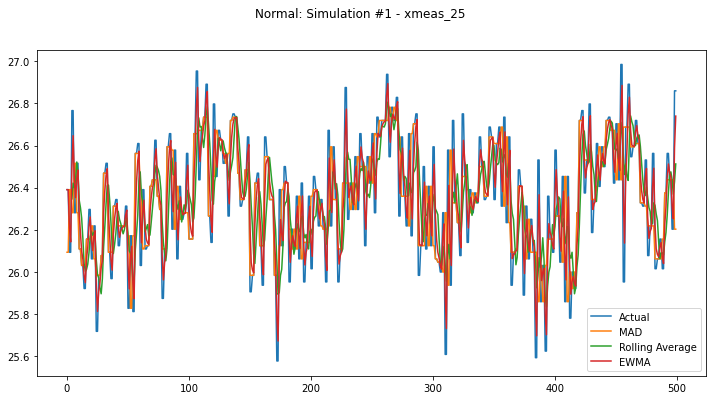

In [114]:
def plot_filtered_simulation_variable(dfs, simulation_run, title, variable, fault_number=0):
    fig, ax = plt.subplots(figsize=(12,6))
    for key in dfs.keys():    
        df = dfs[key]
        df_sim = df[(df.simulationRun == simulation_run)&(df.faultNumber==fault_number)]
        ax.plot(df_sim[variable], label=key)
    
    ax.legend()
    fig.suptitle(f'{title}: Simulation #{simulation_run} - {variable}')

dfs_dict = {'Actual': X_train_normal,  'MAD': X_median_filtered, 'Rolling Average': X_rollavg_filtered, 'EWMA': X_ewma_filtered}#, 'Butter': X_butter_filtered}
plot_filtered_simulation_variable(dfs_dict, 1, 'Normal', 'xmeas_25')

## Modelling

In [124]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([ ('scale', StandardScaler()), ('reshape', LSTMAutoencoderTransformer()), 
                ('encoder', LSTMAutoencoder(epochs=10, batch_size=64, validation_split=0.1))])

 #ae = LSTMAutoencoder(epochs=10, batch_size=64, validation_split=0.1)
# X_train_ae = LSTMAutoencoder.reshape_input(X_train_normal.iloc[:,4:].values)
#ae.fit(X_train_ae)
pipe.fit(X_train_normal.iloc[:,4:].values, None)

ValueError: Found array with dim 3. StandardScaler expected <= 2.